# PMR3404 - Controle I
# Projeto Final (Ball on Wheel)

#### Bruno Fernandes Maione (10770631)
#### Victor Kowalski Martins (10770482)

#### Professores: Eduardo Aoun Tannuri e Newton Maruyama

#### Julho 2021

In [1]:
# Aqui importamos todas as bibliotecas que serão utilizadas no projeto

from sympy import *
from grafico_margens import plot_margins
import warnings
init_printing(use_unicode=True)
warnings.filterwarnings('ignore')
import control.matlab as co
import matplotlib.pyplot as plt
import numpy as np

### 1. Introdução

O presente trabalho tem o intuito de modelar o controle para um sistema denominado "Ball on Wheel". O mesmo consiste numa roda, de inércia não desprezível e acionada por um motor DC, sobre a qual se deve equilibrar uma bola. Um sensor de posição mede o deslocamento da bola em relação ao eixo vertical (isso é, a variável $y(t)$). O objetivo do sistema de controle é manter a bola no topo da roda. Assume-se que não há escorregamento entre as partes.

A Figura a seguir, expõe uma foto real do sistema em conjunto com um desenho esquemático.

![Picture title](Figuras/Real_Esquema.png)

A bola possui massa $m$, momento de inércia $\vartheta$ e raio $r$. A roda possui momento de inércia $\Theta$ e raio $R$.

O torque na roda é dado por $\tau(t)$. A posição angular da roda relativa ao eixo vertical é dada por $\psi(t)$, a posição angular da bola em torno do centro da roda é descrita por $\chi(t)$ e o deslocamento linear em relação ao eixo vertical, considerando que não há escorregamento, é dado por: $y(t) = (R+r)sin(\chi(t))$.

Sendo assim, considerando que as equações de movimento, de dinâmica do motor e os parâmetros físicos do sistema foram expostos no enunciado (e também serão expostos ao longo do desenvolvimento), pode-se prosseguir para a análise da planta para um posterior dimensionamento do controlador preterido.

### 2. Detalhamento da Planta

O primeiro passo a ser efetuado para o presente projeto é a definição e simplificação das equações de movimento, que deverão ser analisadas para uma futura construção do diagrama de blocos de nossa planta.

Como trabalharemos com ângulos pequenos e, principalmente, para possibilitar as transformadas de laplace posteriores, será utilizada a seguinte aproximação para os senos:

$$
sin(x) = x
$$

Tal aproximação, adaptada do primeiro limite fundamental do Cálculo, funciona para ângulos menores de 14º com erro de menor de 1%, o que se trata de uma precisão perfeitamente satisfatória para o projeto.

In [2]:
# Definindo as equações de movimento

t = symbols('t')
s = symbols('s')
m = symbols('m')
r = symbols('r')
R = symbols('R')
g = symbols('g')
v = symbols('vartheta')
O = symbols('Theta')
n = symbols('n')
Kt = symbols('K_t')
Kv = symbols('K_v')
Lm = symbols('L_m')
Rm = symbols('R_m')
T = symbols('Gamma')
# T = O*v + m*(v*(R**2) + O*(r**2))

y, psi, chi, u, i, V = symbols('y, psi, chi, u, i, V', cls=Function)

y = y(t)
y_dot = y.diff()
y_ddot = y_dot.diff()

psi = psi(t)
psi_dot = psi.diff()
psi_ddot = psi_dot.diff()

chi = chi(t)
chi_dot = chi.diff()
chi_ddot = chi_dot.diff()

u = u(t)
u_dot = u.diff()
u_ddot = u_dot.diff()

i = i(t)
i_dot = i.diff()
i_ddot = i_dot.diff()

V = V(t)
V_dot = V.diff()
V_ddot = V_dot.diff()

eq_y = Eq(y ,(R+r)*chi)
eq_psi_ddot = Eq(psi_ddot ,((m*(r**2) + v)*u + m*g*R*v*chi)/T)
eq_chi_ddot = Eq(chi_ddot ,(v*R*u + (O*(r**2) + v*(R**2))*m*g*chi)/(T*(r+R)))
eq_u = Eq(u ,n*Kt*i)
eq_V = Eq(V, Lm*i_dot + Rm*i + Kv*psi_dot)

Uma vez com as equações definidas no código, podemos realizar as manipulações no domínio da frequência, com as transformadas de laplace.

Como a biblioteca Sympy no Python não tem suporte nativo para transformadas de laplace com derivadas e integrais, devemos definir uma função (que aproveite o básico da biblioteca nativa) para abrangir tais funcionalidades e possibilite o uso ao longo das deduções, uma vez que essas peculiaridades com certeza seriam utilizadas.

In [3]:
def laplace_completa(e, t, s):
    """
        Função completa adaptada da biblioteca da transformada de laplace, acrescido do suporte à derivadas e integrais.
        Adaptada de: https://github.com/sympy/sympy/issues/7219#issuecomment-154768904

        Parâmetros
            Inputs: e (expressão simbólica à ser transformada), t (simbólico que representa o tempo), s (simbólico que representa o s de nossa transformada)
            Outputs: res (expressão simbólica após a transformada)
    """

    res = laplace_transform(e, t, s, noconds=True)
    wf = Wild('f')
    lw = LaplaceTransform(wf, t, s)

    for exp in res.find(lw):
        e = exp.match(lw)[wf]
        args = e.args

        if isinstance(e, Derivative):
            # for derivative check that there's only d/dt^n with n>0
            if len(args) == 2 and args[1][0] == t:
                n = args[1][1]
                if n > 0:
                    newexp = s**n * LaplaceTransform(e.args[0], t, s)
                res = res.replace(exp, newexp)

        elif isinstance(e, Integral):
            # for integral check that there's only n consecutive indefinite integrals w.r.t. t
            if all(len(arg) == 1 and arg[0] == t for arg in args[1:]):
                newexp = s**(-len(args[1:])) * LaplaceTransform(args[0], t, s)
                res = res.replace(exp, newexp)

        # caso não tenha derivada ou integral, segue sem entrar nos ifs

    return res

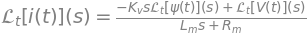

In [4]:
i_s = laplace_completa(i, t, s)
eq_i_s = Eq(i_s, solve(Eq(laplace_completa(eq_V.lhs,t,s), laplace_completa(eq_V.rhs,t,s)), i_s)[0])
eq_i_s

In [5]:
u_s = laplace_completa(u, t, s)
eq_u_s = Eq(u_s, solve(Eq(laplace_completa(eq_u.lhs,t,s), laplace_completa(eq_u.rhs,t,s)), u_s)[0])
eq_u_s

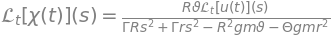

In [6]:
chi_s = laplace_completa(chi, t, s)
eq_chi_s = Eq(chi_s, solve(Eq(laplace_completa(eq_chi_ddot.lhs,t,s), laplace_completa(eq_chi_ddot.rhs,t,s)), chi_s)[0]).simplify()
eq_chi_s

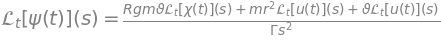

In [7]:
psi_s = laplace_completa(psi, t, s)
eq_psi_s = Eq(psi_s, solve(Eq(laplace_completa(eq_psi_ddot.lhs,t,s), laplace_completa(eq_psi_ddot.rhs,t,s)), psi_s)[0])
eq_psi_s

In [8]:
y_s = laplace_completa(y, t, s)
eq_y_s = Eq(y_s, solve(Eq(laplace_completa(eq_y.lhs,t,s), laplace_completa(eq_y.rhs,t,s)), y_s)[0])
eq_y_s

Com as expressões tranformadas para o domínio da frequência, podemos construir o diagrama de blocos (em malha aberta) de nosso sistema.

![Picture title](Figuras/db-inicial.png)

Chama-se $$\frac{R\vartheta}{R^3ms^2\vartheta-R^2mg\vartheta+R^2mrs^2\vartheta+R\Theta mr^2s^2+R\Theta s^2\vartheta-\Theta mgr^2+\Theta mr^3s^2 + \Theta rs^2\vartheta}$$ de $$G_1(s)$$ e pode-se simplificar o diagrama de blocos da seguinte forma:

![Picture title](Figuras/db-intermediario.png)

Vamos agora realizar as outras operações para obtermos apenas um bloco de nossa planta.
As células a seguir realizam as mesmas, passo à passo, utilizando as funcionalidades do Python.

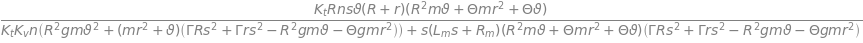

In [9]:
G1 = (eq_chi_s.rhs/u_s).simplify()

Gcima = (((Kt*n)/(Lm*s+Rm))*G1).simplify()

Gbaixo = ((R*g*m*v + (m*r**2+v)/G1)*(Kv/(s*(R**2*m*v + O*m*r**2 + O*v)))).simplify()

Gp = (Gcima/(1+Gcima*Gbaixo)*(R+r)).simplify()

Gp

Portanto, obtemos a função de transferência de nossa planta (malha aberta), substituindo o valor de $$G_1(s)$$, mostrada a seguir.

![Picture title](Figuras/db-final.png)

Como discutido com professores e outros colegas, para ao presente projeto iremos dimensionar nosso controlador para a variável $$Y(s)$$ diretamente.

Repare que agora será necessário realizar tal dimensionamento, para posteriormente fazermos teste com distúrbios no torque da roda, parâmetro físico mais interessante na presente problemática.

A malha fechada com nosso controlador fica, portanto, como mostrado a seguir.

![Picture title](Figuras/db-malha-fechada.png)

### 3. Dimensionamento do controlador

Um controlador PID pode ser pensado da seguinte forma:

$$G_c(s) = K_p \frac{(s+ z_1)(s+z_2)}{s}$$

A tarefa inicial é atribuir a posicao de dois zeros $$z_1$$ e $$z_2$$.

In [10]:
# Celula utilizada para conseguirmos pegar a expressão simbólica e transformá-la para Python, evitando erros na cópia
print_python(Gp)

K_t = Symbol('K_t')
R = Symbol('R')
n = Symbol('n')
s = Symbol('s')
vartheta = Symbol('vartheta')
r = Symbol('r')
m = Symbol('m')
Theta = Symbol('Theta')
K_v = Symbol('K_v')
g = Symbol('g')
Gamma = Symbol('Gamma')
L_m = Symbol('L_m')
R_m = Symbol('R_m')
e = K_t*R*n*s*vartheta*(R + r)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)/(K_t*K_v*n*(R**2*g*m*vartheta**2 + (m*r**2 + vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2)) + s*(L_m*s + R_m)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2))


In [11]:
# Definição dos parâmetros numéricos

s = co.tf("s")

Theta = 0.028 # kg.m^2
R = 0.16 # m
m = 0.048 # kg
vartheta = 2.54e-5 #kg.m^2
r = 0.0296 #m
K_t = 0.1604 # N.m/A
K_v = 0.1186 # V.s/rad
R_m = 12 # ohm
L_m = 1.16e-3 # H
g = 9.8 # m/s^2
n = 40
Gamma = Theta*vartheta + m*(vartheta*(R**2) + Theta*(r**2))


Gp = K_t*R*n*s*vartheta*(R + r)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)/(K_t*K_v*n*(R**2*g*m*vartheta**2 + (m*r**2 + vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2)) + s*(L_m*s + R_m)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2))

Vamos, como boa prática, analisar os polos e zeros de nossa função de transferência em malha aberta com os parâmetros numéricos definidos no $$\textit{briefing}$$ do projeto.

In [12]:
p_g = co.pole(Gp)
z_g = co.zero(Gp)
print(p_g, z_g)

[-1.03425992e+04  5.69671377e+00 -5.72218197e+00 -2.20289160e+00] [0.]


Nossa função de transferência com os valores numéricos fica, em adição, da seguinte forma:

In [20]:
print("VERSAO NAO SIMPLIFICADA")
print(Gp)

# Podemos realizar algumas manobras para simplificar ainda mais nossa funcao de transferencia, printamos sua versao simplificada logo abaixo

# aux_simplifica = 1/(Gp.num[0][0][0])
# Gp = Gp*aux_simplifica/aux_simplifica

# print("VERSAO SIMPLIFICADA")
# print(Gp)

VERSAO NAO SIMPLIFICADA

                              9.492e-12 s
-----------------------------------------------------------------------
8.107e-16 s^4 + 8.387e-12 s^3 + 1.866e-11 s^2 - 2.729e-10 s - 6.021e-10

VERSAO SIMPLIFICADA
0 states have been removed from the model

                         1.171e+04 s
-------------------------------------------------------------
s^4 + 1.034e+04 s^3 + 2.301e+04 s^2 - 3.366e+05 s - 7.427e+05



Vamos agora definir as expressões de nosso controlador em Python.

In [14]:
# Gc é (s+z1)*(s+z2)/s, já cortando o polo em 0 com o zero em 0:

Gc = (s+1)*(s+1)/s
Gpc = co.minreal(Gc*Gp)
print(Gpc)

1 states have been removed from the model

           1.171e+04 s^2 + 2.342e+04 s + 1.171e+04
-------------------------------------------------------------
s^4 + 1.034e+04 s^3 + 2.301e+04 s^2 - 3.366e+05 s - 7.427e+05



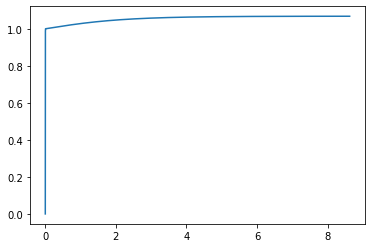

In [15]:
Kp = 1000

# t = np.linspace(0, 6e-3, 10000)
# entrada = np.ones(len(t))*1
# y , t , xout= co.lsim(co.feedback(Kp*Gp*Gc), entrada, t)

y, t = co.step(co.feedback(Kp*Gpc))
plt.figure()
plt.plot(t,y)

In [16]:
co.damp(co.feedback(Kp*Gpc))

_____Eigenvalue______ Damping___ Frequency_
     -9049                     1       9049
     -1294                     1       1294
    -1.169                     1      1.169
    -0.801                     1      0.801


(array([9.04873479e+03, 1.29412282e+03, 1.16896735e+00, 8.01007723e-01]),
 array([1., 1., 1., 1.]),
 array([-9.04873479e+03, -1.29412282e+03, -1.16896735e+00, -8.01007723e-01]))

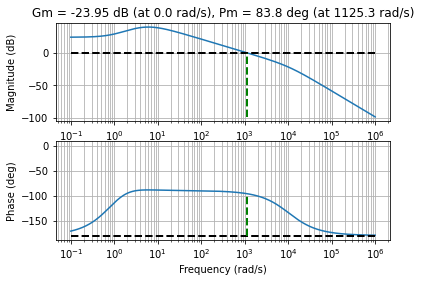

In [17]:
plot_margins(Kp*Gpc)

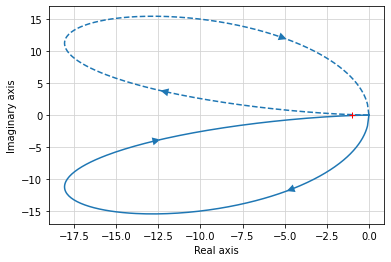

In [18]:
co.nyquist(Kp*Gp)
pass

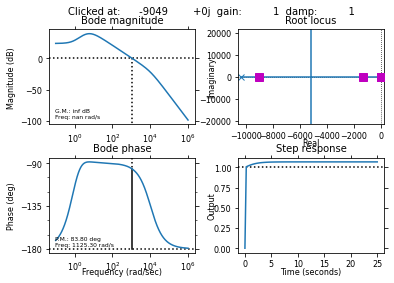

In [19]:
co.sisotool(Kp*Gp*Gc)

![Picture title](Figuras/Sisotool.png)

### 5. Discussões

### 6. Conclusões

Uma vez dimensionado o sistema de controle, obtidos os gráficos e discutidas suas representações, considerando aspectos físicos, pode-se encerrar o presente relatório com conclusões gerais do trabalho. Inicialmente, deve-se ressaltar o caráter físico da problemática, isto é, por ser uma planta com traços e necessidades (requisitos) comuns no ramo da engenharia, dá-se enorme valor ao tratamento de suas equações e à resolução por métodos analíticos e computacionais. Tal valor, combinado com considerações desenvolvidas em diversas linguagens e bibliotecas, agrega valor para à engenharia tanto no sentido acadêmico, quanto no de mercado.

Adicionalmente, dado o caráter didático da disciplina, deve-se citar a relevância do aprofundamento e desenvolvimento de diferentes métodos para a resolução do presente trabalho. Assim como visto na teoria, em aula, pode-se colocar em prática o conhecimento recebido e observar, com os próprios olhos, o trade-off sempre presente na engenharia: entre precisão e esforço analítico-computacional, geralmente conectado com o tempo de obtenção de uma solução. Leva-se, portanto, para a posteridade da equipe, o contato com o traquejo ao se procurar não uma solução ideal, mas sim a solução suficientemente adequada (sempre com segurança) para a realização de projetos futuros e análise de fenômenos físicos.

Por fim, o contato com ferramentas importantes para a indústria atual, como Python e suas bibliotecas (simbólicas, relacionadas à controle e algébricas), completam e agregam ao trabalho mais um aprendizado valoroso. Encerra-se o presente estudo, não só com o treino de habilidades qualitativas, mas também com o aperfeiçoamento de habilidades técnico-operacionais, as quais não são, de modo algum, comparáveis entre si, sendo únicas e importantes de maneiras diferentes para a realização de um estudo acadêmico e de um projeto de engenharia.

### 7. Agradecimentos

Utiliza-se o espaço deste trabalho para realizar um agradecimento aos docentes da disciplina. Não são muitas as matérias que cativam os alunos do início ao fim com aulas e atividades tão interessantes, como Controle I fez com ambos os autores deste projeto. A disciplina se mostrou extremamente divertida e achamos importante ressaltar esses momentos durante nossa graduação. Nosso muito obrigado e até uma próxima!

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4b5d483-a464-4b27-a020-25b9883aaa56' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>